In [1]:
import os
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

In [2]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set dataset path
dataset_path = "/content/drive/MyDrive/dsgp datasets/"


Mounted at /content/drive


In [3]:
# ✅ Check if the dataset exists
if not os.path.exists(dataset_path):
    print(f"❌ Error: Dataset path '{dataset_path}' not found. Please check your Google Drive folder.")
else:
    print(f"✅ Dataset found at: {dataset_path}")

✅ Dataset found at: /content/drive/MyDrive/dsgp datasets/


In [4]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

# ✅ Corrected folder mapping (Use exact names from Drive)
plant_deficiency_mapping = {
    "Rice folder": ["Potassium(K)", "Nitrogen(N)", "Phosphorus(P)"],
    "Banana folder": ["IronB", "MagnesiumB", "PotassiumB"],
    "Coffee folder": ["PotassiumC", "IronC", "MagnesiumC"]
}

# ✅ Define the dataset path
dataset_path = "/content/drive/MyDrive/dsgp datasets"

# ✅ Function to preprocess images
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️ Warning: Could not read {image_path}, skipping...")
        return None
    img = cv2.resize(img, (224, 224))  # Resize for ResNet (224x224)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = img_to_array(img)  # Convert image to array
    img = preprocess_input(img)  # Preprocess for ResNet50
    return img

# ✅ Load images and labels
X_data = []  # Image data
y_labels = []  # Labels for the data
label_mapping = {}  # To store numerical labels for classes
label_index = 0  # Initialize label index

# ✅ Iterate over the plant deficiency mapping and process the images
for plant, deficiencies in plant_deficiency_mapping.items():
    for deficiency in deficiencies:
        deficiency_path = os.path.join(dataset_path, plant, deficiency)
        if os.path.exists(deficiency_path):
            if deficiency not in label_mapping:
                label_mapping[deficiency] = label_index
                label_index += 1

            # Process all images in the deficiency subfolder
            for img_name in os.listdir(deficiency_path):
                img_path = os.path.join(deficiency_path, img_name)
                # Preprocess image
                img = preprocess_image(img_path)

                if img is not None:
                    X_data.append(img)
                    y_labels.append(label_mapping[deficiency])
        else:
            print(f"⚠️ Warning: Directory '{deficiency_path}' not found, skipping...")

# ✅ Convert to NumPy arrays
X_data = np.array(X_data)
y_labels = np.array(y_labels)

print(f"✅ Loaded {len(X_data)} images with {len(set(y_labels))} unique classes.")


✅ Loaded 1884 images with 9 unique classes.


In [5]:
# ✅ Severity Mapping for each deficiency (You can modify this based on your dataset)
severity_mapping = {
    "Potassium(K)": "moderate",  # Example: moderate severity
    "Nitrogen(N)": "mild",  # Example: mild severity
    "Phosphorus(P)": "severe",  # Example: severe severity
    "IronB": "mild",
    "MagnesiumB": "moderate",
    "PotassiumB": "severe",
    "PotassiumC": "mild",
    "IronC": "severe",
    "MagnesiumC": "moderate"
}

# ✅ Encode severity labels as numeric values (e.g., mild=0, moderate=1, severe=2)
severity_encoded = {
    "mild": 0,
    "moderate": 1,
    "severe": 2
}

# ✅ Map severity labels to numeric values
y_severity = []
for deficiency in y_labels:
    plant_deficiency = list(label_mapping.keys())[list(label_mapping.values()).index(deficiency)]
    severity_label = severity_mapping.get(plant_deficiency, "mild")  # Default to "mild" if not found
    severity_numeric = severity_encoded.get(severity_label, 0)  # Default to 0 if not found
    y_severity.append(severity_numeric)

# ✅ Convert to NumPy array
y_severity = np.array(y_severity)

print(f"✅ Encoded severity labels: {len(set(y_severity))} unique severity levels.")


✅ Encoded severity labels: 3 unique severity levels.


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# ✅ Load the ResNet50 model (without the top layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ✅ Add a GlobalAveragePooling layer to flatten the features
x = base_model.output
x = GlobalAveragePooling2D()(x)

# ✅ Create a model for feature extraction
feature_extractor = Model(inputs=base_model.input, outputs=x)

# ✅ Define a function to extract features from an image
def extract_features(img):
    # Reshape and expand the dimensions of the image to match the input format of ResNet50
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    # Extract features using ResNet50 model
    features = feature_extractor.predict(img)
    return features.flatten()  # Flatten the features to 1D

# ✅ Extract features for all images
X_features = []
for img in X_data:
    features = extract_features(img)
    X_features.append(features)

# ✅ Convert features to a NumPy array
X_features = np.array(X_features)

print(f"✅ Extracted features for {len(X_features)} images.")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━

In [7]:
from sklearn.model_selection import train_test_split

# ✅ Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_severity, test_size=0.2, random_state=42)

print(f"✅ Train data: {X_train.shape[0]} samples")
print(f"✅ Test data: {X_test.shape[0]} samples")


✅ Train data: 1507 samples
✅ Test data: 377 samples


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# ✅ Create the neural network model
model = Sequential()

# Input layer (flatten the features)
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))

# Add a Dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Hidden layer
model.add(Dense(256, activation='relu'))

# Add another Dropout layer
model.add(Dropout(0.5))

# Output layer (3 classes: mild, moderate, severe)
model.add(Dense(3, activation='softmax'))

# ✅ Compile the model with RMSprop optimizer
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# ✅ Train the model with accuracy tracking
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,  # You can adjust the number of epochs as needed
                    batch_size=32,  # You can adjust the batch size as needed
                    callbacks=[early_stopping, reduce_lr])  # Add the callbacks here

# ✅ Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"✅ Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4464 - loss: 2.0216 - val_accuracy: 0.8408 - val_loss: 0.5200 - learning_rate: 0.0010
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7385 - loss: 0.6540 - val_accuracy: 0.6472 - val_loss: 0.7858 - learning_rate: 0.0010
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7496 - loss: 0.6065 - val_accuracy: 0.8462 - val_loss: 0.3328 - learning_rate: 0.0010
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7833 - loss: 0.5152 - val_accuracy: 0.8488 - val_loss: 0.3306 - learning_rate: 0.0010
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8430 - loss: 0.3895 - val_accuracy: 0.8223 - val_loss: 0.4387 - learning_rate: 0.0010
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8535 - loss: 0.3830 - val_accuracy: 0.8462 - val_loss: 0.3684 - learning_rate: 0.0010
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8555 - loss: 0.3657 - val_accuracy: 0.90

In [9]:
# Retrieve training accuracy from history
train_accuracy = history.history['accuracy']

# Print the last training accuracy (after the final epoch)
print(f"✅ Final Training Accuracy: {train_accuracy[-1]:.4f}")


✅ Final Training Accuracy: 0.9071


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


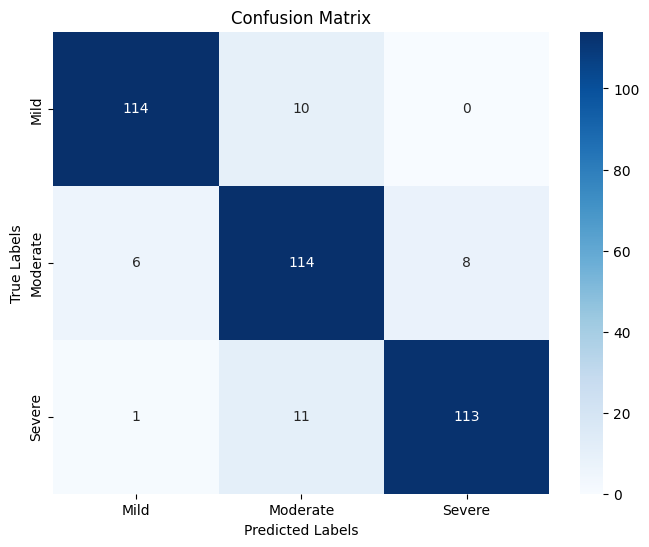

Confusion Matrix:
[[114  10   0]
 [  6 114   8]
 [  1  11 113]]


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with highest probability

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Mild', 'Moderate', 'Severe'], yticklabels=['Mild', 'Moderate', 'Severe'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the confusion matrix for further inspection
print("Confusion Matrix:")
print(cm)


In [13]:
# Save the model to a file
model.save('/content/FINALMODELforSeverity.h5')  # Save model to your desired location
print("Model saved successfully as 'FINALMODELforSeverity.h5'")


Model saved successfully as 'FINALMODELforSeverity.h5'


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


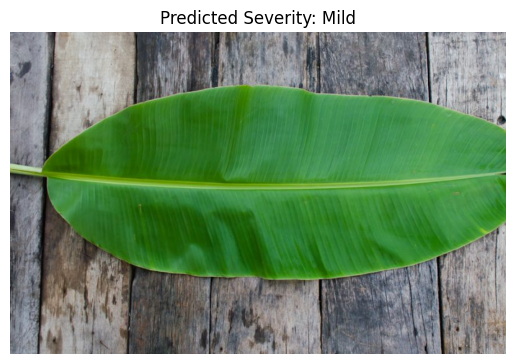

Predicted Severity: Mild


In [21]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer to get 2048-dimensional features
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Create a model to extract features from ResNet50
model_input = base_model.input
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Flatten the output to 2048 dimensions
feature_extractor_model = Model(inputs=model_input, outputs=x)

# Function to preprocess user input image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️ Warning: Could not read {image_path}, skipping...")
        return None
    img = cv2.resize(img, (224, 224))  # Resize for ResNet (224x224)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = img_to_array(img)  # Convert image to array
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img.astype('float32')  # Ensure the image data type is float32
    return img

# Function to predict severity
def predict_severity(image_path):
    # Preprocess the image
    img = preprocess_image(image_path)
    if img is None:
        return "Error: Could not process image."

    # Extract features using the ResNet50 model
    features = feature_extractor_model.predict(img)

    # Load your custom classification model (assumed to be already trained)
    model = load_model('/content/FINALMODELforSeverity.h5')  # Replace with the actual path of your model

    # Predict severity class (mild, moderate, severe)
    try:
        prediction = model(features)  # Pass features to the custom model
    except Exception as e:
        print(f"Error during prediction: {e}")
        return "Error: Prediction failed."

    # Get predicted class (0: mild, 1: moderate, 2: severe)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Map the predicted class back to severity labels
    severity_labels = ["Mild", "Moderate", "Severe"]
    predicted_severity = severity_labels[predicted_class]

    # Plot the input image
    img_display = cv2.imread(image_path)
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(img_display)
    plt.title(f"Predicted Severity: {predicted_severity}")
    plt.axis('off')  # Remove axis
    plt.show()

    return predicted_severity

# Example usage: test with an image file path (you can change this to the file input)
image_path = "/content/healthyy.jpg"
predicted_severity = predict_severity(image_path)
print(f"Predicted Severity: {predicted_severity}")
